# Titanic Data Analysis
**Data Cleaning**



In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [2]:
df = pd.read_csv('titanic_data.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [4]:
df.describe()

/Users/johnhagler/anaconda/lib/python2.7/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,NaN,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,NaN,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,NaN,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Missing values in Age, Cabin, and Embarked

## Determine missing values

### Embarked

In [5]:
df.groupby('Embarked').count()['PassengerId']

Embarked
C    168
Q     77
S    644
Name: PassengerId, dtype: int64

Most of the passengers embarked from 'S'.  There are two missing values.  We will fill these with 'S'.

In [6]:
df['Embarked'].fillna('S', inplace=True)

Replace the letter code, with the port.

In [7]:
def get_port_name(letter):
    if letter == 'C':
        return 'Cherbourg'
    elif letter == 'Q':
        return 'Queenstown'
    elif letter == 'S':
         return 'Southampton'
    else:
        return letter
    
df['embarked_port'] = df['Embarked'].apply(get_port_name)

### Cabin
The Cabin field is missing 687 (77%) values.  We are not be able to accurately impute the missing values.

### Age
The Age field is missing 177 (20%) values.  There does not appear to be a lot of good data to be able to impute specific ages.  Taking the mean age and replacing the missing values is an option, but it may too strongly reinforce the current mean.  An option may be to create a new feature, "PassengerGroup" that divides passengers into "Men, women, and children".  Sex, age, and the passenger's salutation can be used to assign the groups.  The salutation can be extracted from the name.  This field helps give us additional information for passengers whose age is missing from the data.  

Males over the age of 18 or passengers with the salutaiton of "Mr" or "Dr" can be considered men  Females over the age of 18 or passengers with the saluation of "Mrs" can be considered women.  Passengers under the age of 18 or with the salutation of miss or master can be considered children.

In [8]:
def get_salutation(name):
    m = re.search('(.*,)(.*)(\..*)', name)
    return m.group(2).strip()
df['salutation'] = df['Name'].apply(get_salutation)

In [9]:
df[['salutation','Name']].head()

,salutation,Name
0,Mr,"Braund, Mr. Owen Harris"
1,Mrs,"Cumings, Mrs. John Bradley (Florence Briggs Th..."
2,Miss,"Heikkinen, Miss. Laina"
3,Mrs,"Futrelle, Mrs. Jacques Heath (Lily May Peel)"
4,Mr,"Allen, Mr. William Henry"


In [10]:
def get_passenger_group(sex, age, name, salutation):
    if (sex == 'male' and age >= 18) or (salutation == 'Mr' or salutation == 'Dr'):
        return 'Men'
    elif (sex == 'female' and age >= 18) or (salutation == 'Mrs'):
        return 'Women'
    elif (age < 18) or (salutation == 'Miss' or salutation == 'Master'):
        return 'Children'
    else:
        return 'Unknown'
    
df['passenger_group'] = df.apply(lambda x: get_passenger_group(x['Sex'], x['Age'], x['Name'], x['salutation']), axis=1)

In [11]:
df[df['passenger_group'] == 'Unknown'].count()['PassengerId']

0

All passengers have been assigned a PassengerGroup.

## Outliers

## Fare

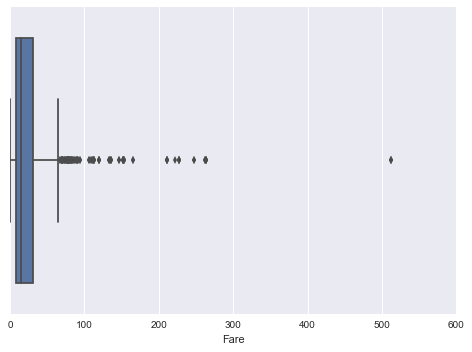

In [12]:
sns.boxplot(df['Fare'])

There appears to be an extreme outlier for "Fare".  However, after reseasrching fares pade for first class on the Titanic, this value may be accurate.

## Identify family groups

In [13]:
def has_family(sibsp, parch):
    return sibsp + parch > 0

df['has_family'] = df.apply(lambda x: has_family(x['SibSp'], x['Parch']), axis=1)


In [14]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,embarked_port,salutation,passenger_group,has_family
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Southampton,Mr,Men,True
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Cherbourg,Mrs,Women,True
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Southampton,Miss,Women,False
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Southampton,Mrs,Women,True
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Southampton,Mr,Men,False


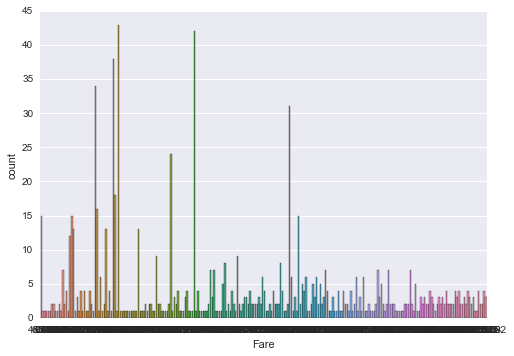

In [109]:
bins = np.arange(0, 100, 10)
np.append(bins, [100, 500])

array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 500])

In [18]:
def bin_fare(fare):
    return round(fare * 10, 0) / 10
df['fare_binned'] = df['Fare'].apply(bin_fare)

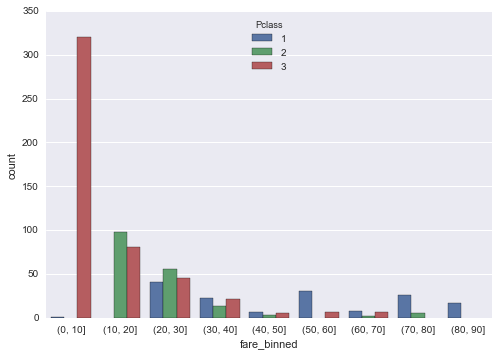

In [110]:
df['fare_binned'] = pd.cut(df['Fare'], bins=bins, precision=1)
df['fare_binned'] = df['fare_binned'].astype('category')
#sns.factorplot(data=df, x='fare_binned', y='Survived', kind='bar', aspect=3)
sns.countplot(data=df, x='fare_binned', hue='Pclass')

In [63]:
df.groupby('fare_binned', as_index=False).mean()


,fare_binned,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,has_family
0,"(0, 5]",626.000000,0.000000,2.000000,26.500000,0.000000,0.000000,4.506250,0.000000
1,"(5, 10]",447.006270,0.206897,3.000000,27.955595,0.084639,0.031348,7.887172,0.078370
2,"(10, 15]",453.918033,0.385246,2.270492,29.817281,0.172131,0.180328,12.540575,0.245902
3,"(15, 20]",392.175439,0.508772,2.842105,22.166585,0.824561,0.543860,16.745611,0.824561
4,"(20, 50]",443.745370,0.416667,2.004630,29.304486,1.009259,0.870370,29.425772,0.638889
5,"(50, 100]",448.102804,0.654206,1.327103,36.633333,1.102804,0.392523,69.306270,0.719626
6,"(100, 200]",447.030303,0.757576,1.000000,32.430667,0.606061,0.787879,131.108200,0.727273
7,"(200, 512.3]",475.650000,0.700000,1.000000,31.166667,0.750000,1.050000,279.308545,0.650000


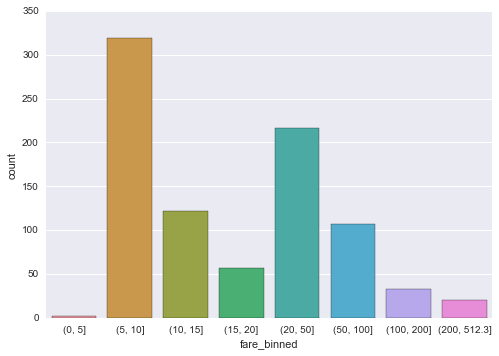

In [79]:
sns.countplot(data=df, x='fare_binned')

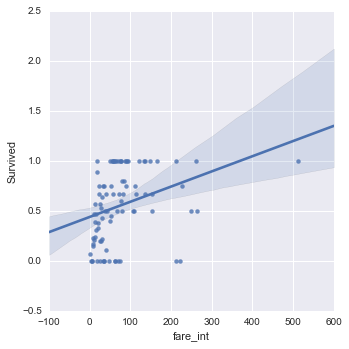

In [76]:
df['fare_int'] = df['Fare'].apply(lambda x: round(x/1,0)*1)
#sns.factorplot(data=df.groupby('fare_int', as_index=False).mean(), x='fare_int', y='Survived', kind='bar')
sns.lmplot(data=df.groupby('fare_int', as_index=False).mean(), x='fare_int', y='Survived')

In [19]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,embarked_port,salutation,passenger_group,has_family,fare_binned
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Southampton,Mr,Men,True,7.3
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Cherbourg,Mrs,Women,True,71.3
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Southampton,Miss,Women,False,7.9
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Southampton,Mrs,Women,True,53.1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Southampton,Mr,Men,False,8.1


In [15]:
df.to_csv('titanic_data_cleaned.csv')

# PROJECT SPECIFICATION
*Investigate a Dataset*

## Code Functionality

**Does the code work?**

All code is functional and produces no errors when run. The code given is sufficient to reproduce the results described.

**Does the project use NumPy and Pandas appropriately?**

The project uses NumPy arrays and Pandas Series and DataFrames where appropriate rather than Python lists and dictionaries. Where possible, vectorized operations and built-in functions are used instead of loops.

**Does the project use good coding practices?**

The code makes use of functions to avoid repetitive code. The code contains good comments and variable names, making it easy to read.

## Quality of Analysis

**Is a question clearly posed?**

The project clearly states one or more questions, then addresses those questions in the rest of the analysis.

## Data Wrangling Phase

**Is the data cleaning well documented?**

The project documents any changes that were made to clean the data, such as merging multiple files, handling missing values, etc.

## Exploration Phase

**Is the data explored in many ways?**

The project investigates the stated question(s) from multiple angles. At least three variables are investigated using both single-variable (1d) and multiple-variable (2d) explorations.

**Are there a variety of relevant visualizations and statistical summaries?**

The project's visualizations are varied and show multiple comparisons and trends. Relevant statistics are computed throughout the analysis when an inference is made about the data.

**At least two kinds of plots should be created as part of the explorations.**

## Conclusions Phase

**Has the student correctly communicated tentativeness of findings?**

The results of the analysis are presented such that any limitations are clear. The analysis does not state or imply that one change causes another based solely on a correlation.


## Communication Phase

**Is the flow of the analysis easy to follow?**

Reasoning is provided for each analysis decision, plot, and statistical summary.

**Is the data visualized using appropriate plots and parameter choices?**

Visualizations made in the project depict the data in an appropriate manner that allows plots to be readily interpreted.

# References
> https://www.kaggle.com/c/titanic/data

> https://www.encyclopedia-titanica.org/titanic-deckplans/d-deck.html

> https://www.kaggle.com/c/titanic/forums/t/2955/how-do-you-cope-with-missing-values

> https://www.kaggle.com/mrisdal/titanic/exploring-survival-on-the-titanic/discussion

> https://www.analyticsvidhya.com/blog/2015/10/inferential-descriptive-statistics-beginners-r/